In [1]:
library(MatchIt)
library(dplyr)
library(tidyr)
library(sparklyr)
library(ggplot2)
library(ggridges)
library(gridExtra)

library(effsize)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
config <- spark_config()
config$`sparklyr.shell.driver-memory` <- "10G"
config$`sparklyr.shell.executor-memory` <- "10G"
sc <- spark_connect(master = "local", config = config)

Warning message in file(input, encoding = "UTF-8"):
“'raw = FALSE' but '/cluster/home/config.yml' is not a regular file”
Warning message in readLines(con):
“cannot open file '/cluster/home/config.yml': Permission denied”


In [3]:
spark_tbl_handle <- spark_read_parquet(sc, "bolus", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/measurements_around_bolus/2020-12-05")
df_bolus <- collect(spark_tbl_handle)
spark_tbl_handle <- spark_read_parquet(sc, "nobolus", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/measurements_around_non_bolus/2020-12-05")
df_no_bolus <- collect(spark_tbl_handle)
spark_tbl_handle <- spark_read_parquet(sc, "bolus_info", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/bolus_isolated/2020-12-05/augmented/2020-12-05")
df_bolus_base_info <- collect(spark_tbl_handle)
spark_tbl_handle <- spark_read_parquet(sc, "no_bolus_info", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/non_bolus/2020-12-05/augmented/2020-12-05")
df_no_bolus_base_info <- collect(spark_tbl_handle)

#merge bolus and additional bolus info
df_bolus_augm <- merge(df_bolus,df_bolus_base_info,by=c("patientid","bolusid"))
df_no_bolus_augm <- merge(df_no_bolus,df_no_bolus_base_info,by=c("patientid","bolusid"))

In [5]:
plot_vars = numeric_cov
plot_vars_name <- c('Time since admission', 'Patient age', 'APACHE II score', 'Heart rate (HR)', 'Systolic blood pressure', 'Mean arterial blood pressure (MAP)', 'MAP trend', 'HR trend', 'Norepinephrine rate', 'Epinephrine rate', 'Dobutamine rate', 'Milrinone rate', 'Levosimendan rate', 'Theophyllin rate', 'Vasopressin rate', 'Pulmonary artery mean pressure', 'Pulmonary capillary wedge pressure', 'Cardiac output', 'Mixed venous oxygen saturation', 'Central venous pressure', 'Urine output', 'Arterial Lactate', 'Total intravenous fluid last 30 minutes', 'Total intravenous fluid last 2 hours')
spark_tbl_handle <- spark_read_parquet(sc, "bolus", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/psm_cardiac/2020-12-30")
df_psm <- collect(spark_tbl_handle)

std_errors <- matrix(ncol=3, nrow=length(plot_vars)*2)
for(i in 1:length(numeric_cov)){
    v = plot_vars[i]
    std_errors[i,1] <- plot_vars_name[i]
    std_errors[i,2] <- 'Before matching'
    std_errors[i,3] <- abs(cohen.d(unlist(df_ana[, v]) ~ unlist(df_ana[,'bolus']))$estimate) * 100
}

for(i in 1:length(numeric_cov)){
    v = plot_vars[i]
    std_errors[length(plot_vars)+i,1] <- plot_vars_name[i]
    std_errors[length(plot_vars)+i,2] <- 'After matching'
    std_errors[length(plot_vars)+i,3] <- abs(cohen.d(unlist(df_psm[, v]) ~ unlist(df_psm[,'bolus']))$estimate) * 100
}
output <- data.frame(std_errors)
output$X3 <- as.numeric(as.character(output$X3))

Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen.d.formula(unlist(df_ana[, v]) ~ unlist(df_ana[, "bolus"])):
“Cohercing rhs of formula to factor”
Warning message in cohen

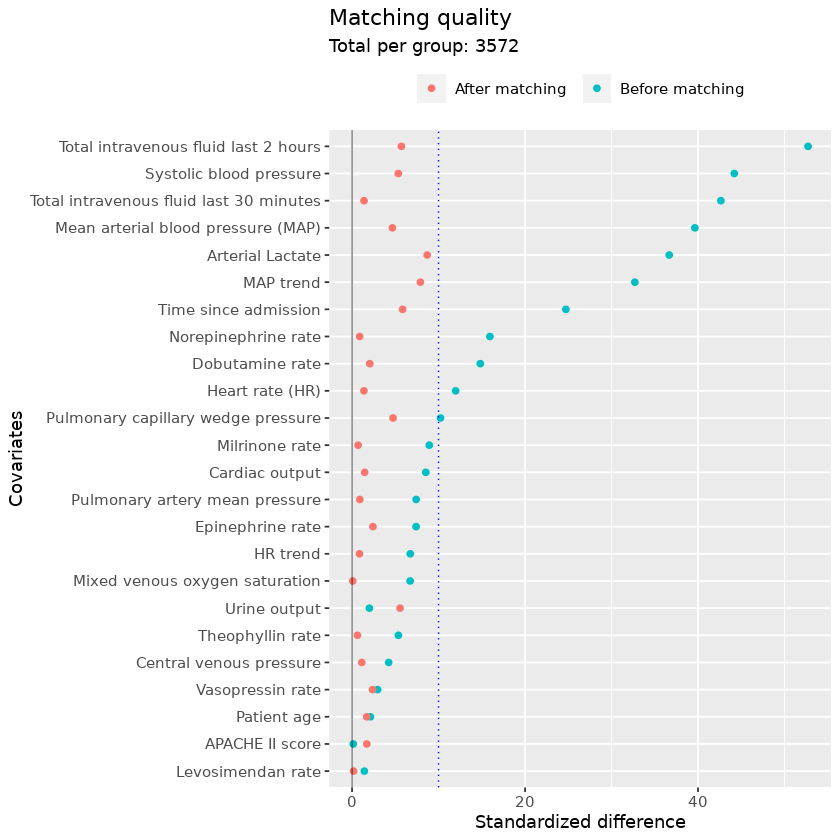

In [6]:
ggplot(output) +
    geom_point(aes(x = X3, y = reorder(X1, X3, max), color=X2)) + 
    labs(colour = NULL, title="Matching quality", subtitle=paste("Total per group:", nrow(df_psm)/2)) +
    xlab("Standardized difference") +
    ylab("Covariates") +
    geom_vline(xintercept = 10, linetype="dotted", color = "blue", size=0.4) +
    geom_vline(xintercept = 0, size=0.2) +
    theme(legend.position="top")

In [7]:
#disconnect spark
spark_disconnect(sc)